# Setup

In [1]:
# dependencies
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, mean_squared_error, brier_score_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Process Data

## Regular Season

In [2]:
# import data
w_reg_detailed = pd.read_csv("data/WRegularSeasonDetailedResults.csv")

In [3]:
w_reg_detailed

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,2025,131,3471,75,3413,66,A,0,26,62,4,19,19,28,8,31,10,11,6,1,20,24,67,9,29,9,14,9,26,14,10,6,5,22
81704,2025,132,3192,66,3476,49,H,0,23,55,3,21,17,18,10,22,11,9,8,1,8,21,57,4,20,3,4,14,22,14,17,4,1,17
81705,2025,132,3250,74,3119,62,H,0,27,45,5,14,15,17,5,25,15,15,6,0,12,25,56,6,17,6,10,8,13,10,10,5,0,20
81706,2025,132,3293,83,3125,62,N,0,28,54,14,28,13,15,5,33,21,13,2,3,15,24,68,2,21,12,14,12,22,11,7,5,0,16


In [4]:
w_reg_winners = w_reg_detailed.copy()

winner_cols = {'WTeamID':'TeamID', 'WScore':'Pts', 'LTeamID':'Opp_TeamID', 'LScore':'Opp_Pts', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3', 
               'WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR', 'WAst':'Ast', 'WTO':'TO', 'WStl': 'Stl', 'WBlk': 'Blk', 
               'WPF': 'PF', 'LFGM':'Opp_FGM', 'LFGA':'Opp_FGA', 'LFGM3':'Opp_FGM3', 'LFGA3':'Opp_FGA3', 'LFTM':'Opp_FTM', 'LFTA':'Opp_FTA', 
               'LOR':'Opp_OR', 'LDR':'Opp_DR', 'LAst':'Opp_Ast', 'LTO':'Opp_TO', 'LStl':'Opp_Stl', 'LBlk': 'Opp_Blk', 'LPF': 'Opp_PF'}

w_reg_winners= w_reg_winners.rename(columns=winner_cols)
w_reg_winners

,Season,DayNum,TeamID,Pts,Opp_TeamID,Opp_Pts,WLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,2025,131,3471,75,3413,66,A,0,26,62,4,19,19,28,8,31,10,11,6,1,20,24,67,9,29,9,14,9,26,14,10,6,5,22
81704,2025,132,3192,66,3476,49,H,0,23,55,3,21,17,18,10,22,11,9,8,1,8,21,57,4,20,3,4,14,22,14,17,4,1,17
81705,2025,132,3250,74,3119,62,H,0,27,45,5,14,15,17,5,25,15,15,6,0,12,25,56,6,17,6,10,8,13,10,10,5,0,20
81706,2025,132,3293,83,3125,62,N,0,28,54,14,28,13,15,5,33,21,13,2,3,15,24,68,2,21,12,14,12,22,11,7,5,0,16


In [5]:
w_reg_losers = w_reg_detailed.copy()

loser_cols = {'WTeamID':'Opp_TeamID', 'WScore':'Opp_Pts', 'LTeamID':'TeamID', 'LScore':'Pts', 'WFGM':'Opp_FGM', 'WFGA':'Opp_FGA', 'WFGM3':'Opp_FGM3', 
               'WFGA3':'Opp_FGA3', 'WFTM':'Opp_FTM', 'WFTA':'Opp_FTA', 'WOR':'Opp_OR', 'WDR':'Opp_DR', 'WAst':'Opp_Ast', 'WTO':'Opp_TO', 'WStl': 'Opp_Stl',
                'WBlk': 'Opp_Blk', 'WPF': 'Opp_PF', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3', 'LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA', 
               'LOR':'OR', 'LDR':'DR', 'LAst':'Ast', 'LTO':'TO', 'LStl':'Stl', 'LBlk': 'Blk', 'LPF': 'PF'}

w_reg_losers = w_reg_losers.rename(columns=loser_cols)
w_reg_losers

,Season,DayNum,Opp_TeamID,Opp_Pts,TeamID,Pts,WLoc,NumOT,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,2025,131,3471,75,3413,66,A,0,26,62,4,19,19,28,8,31,10,11,6,1,20,24,67,9,29,9,14,9,26,14,10,6,5,22
81704,2025,132,3192,66,3476,49,H,0,23,55,3,21,17,18,10,22,11,9,8,1,8,21,57,4,20,3,4,14,22,14,17,4,1,17
81705,2025,132,3250,74,3119,62,H,0,27,45,5,14,15,17,5,25,15,15,6,0,12,25,56,6,17,6,10,8,13,10,10,5,0,20
81706,2025,132,3293,83,3125,62,N,0,28,54,14,28,13,15,5,33,21,13,2,3,15,24,68,2,21,12,14,12,22,11,7,5,0,16


In [6]:
# re-order losers df before concat
w_reg_losers = w_reg_losers[list(w_reg_winners.columns)]
w_reg_teams = pd.concat([w_reg_winners, w_reg_losers], axis=0)
w_reg_teams['TeamSeasonID'] = w_reg_teams['TeamID'].astype(str) + "_" + w_reg_teams['Season'].astype(str)
w_reg_teams

,Season,DayNum,TeamID,Pts,Opp_TeamID,Opp_Pts,WLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,TeamSeasonID
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19,3103_2010
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27,3104_2010
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15,3110_2010
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14,3111_2010
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14,3119_2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,2025,131,3413,66,3471,75,A,0,24,67,9,29,9,14,9,26,14,10,6,5,22,26,62,4,19,19,28,8,31,10,11,6,1,20,3413_2025
81704,2025,132,3476,49,3192,66,H,0,21,57,4,20,3,4,14,22,14,17,4,1,17,23,55,3,21,17,18,10,22,11,9,8,1,8,3476_2025
81705,2025,132,3119,62,3250,74,H,0,25,56,6,17,6,10,8,13,10,10,5,0,20,27,45,5,14,15,17,5,25,15,15,6,0,12,3119_2025
81706,2025,132,3125,62,3293,83,N,0,24,68,2,21,12,14,12,22,11,7,5,0,16,28,54,14,28,13,15,5,33,21,13,2,3,15,3125_2025


In [7]:
# Get correct Home, Away, Neutral for each team in each game
w_reg_teams['Loc'] = np.where((w_reg_teams['Pts']<w_reg_teams['Opp_Pts']) & (w_reg_teams['WLoc']=='H'), 'A', 
                              np.where((w_reg_teams['Pts']<w_reg_teams['Opp_Pts']) & (w_reg_teams['WLoc']=='A'), 'H', w_reg_teams['WLoc']))
w_reg_teams['Loc'].value_counts()

Loc
H    74407
A    74407
N    14602
Name: count, dtype: int64

In [8]:
# average values
w_reg_teams_grp = w_reg_teams[['TeamSeasonID', 'TeamID', 'Season', 'Pts', 'Opp_Pts']+list(w_reg_teams.columns)[7:34]]\
                    .groupby(['TeamSeasonID', 'TeamID', 'Season']).mean().reset_index()
w_reg_teams_grp

,TeamSeasonID,TeamID,Season,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF
0,3101_2014,3101,2014,70.000000,69.913043,0.000000,25.086957,59.565217,8.521739,26.652174,11.304348,17.608696,12.217391,23.130435,13.391304,18.304348,8.956522,3.217391,18.521739,24.956522,58.000000,4.652174,14.826087,15.347826,21.869565,13.304348,26.043478,12.826087,18.826087,9.086957,2.304348,18.826087
1,3101_2015,3101,2015,65.040000,62.640000,0.040000,21.720000,57.600000,7.280000,26.040000,14.320000,20.440000,15.320000,24.560000,13.040000,18.640000,10.920000,3.400000,17.280000,22.440000,57.880000,5.840000,18.640000,11.920000,17.160000,13.800000,24.440000,13.200000,18.840000,10.200000,3.680000,19.080000
2,3101_2016,3101,2016,73.200000,63.200000,0.040000,24.560000,58.320000,7.680000,23.080000,16.400000,23.680000,14.680000,25.120000,14.000000,16.920000,9.560000,4.680000,16.760000,23.160000,61.400000,5.440000,19.760000,11.440000,16.920000,15.680000,22.440000,12.400000,18.000000,9.160000,3.080000,21.840000
3,3101_2017,3101,2017,70.888889,64.074074,0.037037,23.962963,57.777778,8.481481,25.555556,14.481481,20.259259,15.666667,24.851852,15.259259,17.259259,7.333333,3.740741,16.888889,23.296296,57.555556,5.037037,16.851852,12.444444,17.592593,12.037037,20.925926,12.629630,15.444444,9.666667,4.000000,20.148148
4,3101_2018,3101,2018,65.923077,68.884615,0.000000,22.615385,54.038462,8.461538,25.423077,12.230769,16.384615,12.538462,21.500000,13.307692,17.730769,7.115385,4.076923,18.538462,24.230769,57.269231,6.307692,18.769231,14.115385,19.038462,13.538462,20.769231,13.269231,14.884615,8.692308,2.384615,17.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,3477_2025,3477,2025,60.888889,72.185185,0.074074,22.481481,59.666667,7.074074,21.925926,8.851852,12.296296,6.962963,23.037037,13.074074,15.259259,6.259259,3.185185,17.296296,26.925926,63.296296,5.888889,18.777778,12.444444,18.185185,11.370370,27.481481,14.444444,13.074074,8.185185,3.037037,13.000000
5598,3478_2024,3478,2024,57.031250,60.250000,0.031250,20.781250,56.593750,4.593750,16.218750,10.875000,14.906250,10.343750,21.187500,11.625000,13.562500,8.875000,3.250000,13.468750,22.375000,56.812500,6.812500,22.062500,8.687500,13.000000,11.593750,23.375000,14.312500,15.875000,7.125000,2.906250,15.281250
5599,3478_2025,3478,2025,53.870968,68.967742,0.064516,18.129032,51.387097,6.322581,20.193548,11.290323,15.000000,7.290323,21.548387,9.741935,15.838710,5.258065,1.741935,13.709677,26.193548,60.032258,8.548387,24.677419,8.032258,10.935484,9.838710,23.677419,16.580645,11.870968,7.806452,2.548387,15.677419
5600,3479_2025,3479,2025,62.791667,70.500000,0.125000,21.500000,52.791667,6.666667,20.916667,13.125000,18.250000,5.291667,22.375000,10.458333,17.791667,5.666667,1.208333,18.708333,26.375000,58.750000,4.791667,16.208333,12.958333,18.375000,8.375000,24.375000,12.375000,15.333333,8.875000,2.375000,19.666667


In [9]:
# calculate additional features
w_feat = w_reg_teams_grp.copy()
w_feat = w_feat.drop(columns=['TeamID', 'Season'])
w_feat['Margin'] = w_feat['Pts'] - w_feat['Opp_Pts']
w_feat['FGp'] = w_feat['FGM'] / w_feat['FGA']
w_feat['FG3p'] = w_feat['FGM3'] / w_feat['FGA3']
w_feat['FTp'] = w_feat['FTM'] / w_feat['FTA']
w_feat['TR'] = w_feat['OR'] + w_feat['DR']
w_feat['Opp_FGp'] = w_feat['Opp_FGM'] / w_feat['Opp_FGA']
w_feat['Opp_FG3p'] = w_feat['Opp_FGM3'] / w_feat['Opp_FGA3']
w_feat['Opp_FTp'] = w_feat['Opp_FTM'] / w_feat['Opp_FTA']
w_feat['Opp_TR'] = w_feat['Opp_OR'] + w_feat['Opp_DR']
w_feat['ORp'] = w_feat['OR'] / w_feat['FGA']
w_feat['DRp'] = w_feat['DR'] / w_feat['Opp_FGA']
w_feat['Opp_ORp'] = w_feat['Opp_OR'] / w_feat['Opp_FGA']
w_feat['Opp_DRp'] = w_feat['Opp_DR'] / w_feat['FGA']
w_feat['FGA3p'] = w_feat['FGA3'] / w_feat['FGA']
w_feat['Opp_FGA3p'] = w_feat['Opp_FGA3'] / w_feat['Opp_FGA']
w_feat['Ast_p'] = w_feat['Ast'] / w_feat['FGM']
w_feat['Opp_Ast_p'] = w_feat['Opp_Ast'] / w_feat['Opp_FGM']
w_feat['TO_p'] = w_feat['TO'] / (w_feat['FGA'] + w_feat['FTA']/2)
w_feat['Opp_TO_p'] = w_feat['Opp_TO'] / (w_feat['Opp_FGA'] + w_feat['Opp_FTA']/2)
w_feat['Pos'] = w_feat['TO'] + w_feat['FGA'] + (w_feat['FTA']/2)
w_feat['Opp_Pos'] = w_feat['Opp_TO'] + w_feat['Opp_FGA'] + (w_feat['Opp_FTA']/2)
w_feat['Blk_p'] = w_feat['Blk'] / w_feat['Opp_FGA']
w_feat['Opp_Blk_p'] = w_feat['Opp_Blk'] / w_feat['FGA']
w_feat['TSp'] = w_feat['Pts'] / (2*(w_feat['FGA']+0.44*w_feat['FTA']))
w_feat['Opp_TSp'] = w_feat['Opp_Pts'] / (2*(w_feat['Opp_FGA']+0.44*w_feat['Opp_FTA']))
w_feat.head()

,TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp
0,3101_2014,70.000000,69.913043,0.000000,25.086957,59.565217,8.521739,26.652174,11.304348,17.608696,12.217391,23.130435,13.391304,18.304348,8.956522,3.217391,18.521739,24.956522,58.000000,4.652174,14.826087,15.347826,21.869565,13.304348,26.043478,12.826087,18.826087,9.086957,2.304348,18.826087,0.086957,0.421168,0.319739,0.641975,35.347826,0.430285,0.313783,0.701789,39.347826,0.205109,0.398801,0.229385,0.437226,0.447445,0.255622,0.533795,0.513937,0.267727,0.273100,86.673913,87.760870,0.055472,0.038686,0.519959,0.516935
1,3101_2015,65.040000,62.640000,0.040000,21.720000,57.600000,7.280000,26.040000,14.320000,20.440000,15.320000,24.560000,13.040000,18.640000,10.920000,3.400000,17.280000,22.440000,57.880000,5.840000,18.640000,11.920000,17.160000,13.800000,24.440000,13.200000,18.840000,10.200000,3.680000,19.080000,2.400000,0.377083,0.279570,0.700587,39.880000,0.387699,0.313305,0.694639,38.240000,0.265972,0.424326,0.238424,0.424306,0.452083,0.322046,0.600368,0.588235,0.274845,0.283479,86.460000,85.300000,0.058742,0.063889,0.488335,0.478677
2,3101_2016,73.200000,63.200000,0.040000,24.560000,58.320000,7.680000,23.080000,16.400000,23.680000,14.680000,25.120000,14.000000,16.920000,9.560000,4.680000,16.760000,23.160000,61.400000,5.440000,19.760000,11.440000,16.920000,15.680000,22.440000,12.400000,18.000000,9.160000,3.080000,21.840000,10.000000,0.421125,0.332756,0.692568,39.800000,0.377199,0.275304,0.676123,38.120000,0.251715,0.409121,0.255375,0.384774,0.395748,0.321824,0.570033,0.535406,0.241163,0.257658,87.080000,87.860000,0.076221,0.052812,0.532447,0.459003
3,3101_2017,70.888889,64.074074,0.037037,23.962963,57.777778,8.481481,25.555556,14.481481,20.259259,15.666667,24.851852,15.259259,17.259259,7.333333,3.740741,16.888889,23.296296,57.555556,5.037037,16.851852,12.444444,17.592593,12.037037,20.925926,12.629630,15.444444,9.666667,4.000000,20.148148,6.814815,0.414744,0.331884,0.714808,40.518519,0.404762,0.298901,0.707368,32.962963,0.271154,0.431789,0.209138,0.362179,0.442308,0.292793,0.636785,0.542130,0.254159,0.232766,85.166667,81.796296,0.064994,0.069231,0.531466,0.490641
4,3101_2018,65.923077,68.884615,0.000000,22.615385,54.038462,8.461538,25.423077,12.230769,16.384615,12.538462,21.500000,13.307692,17.730769,7.115385,4.076923,18.538462,24.230769,57.269231,6.307692,18.769231,14.115385,19.038462,13.538462,20.769231,13.269231,14.884615,8.692308,2.384615,17.230769,-2.961538,0.418505,0.332829,0.746479,34.038462,0.423103,0.336066,0.741414,34.307692,0.232028,0.375420,0.236400,0.384342,0.470463,0.327737,0.588435,0.547619,0.284920,0.222862,79.961538,81.673077,0.071189,0.044128,0.538168,0.524666


## Last 14 days

In [10]:
w_reg_teams['Opp_TeamSeasonID'] = w_reg_teams['Opp_TeamID'].astype(str) + "_" + w_reg_teams['Season'].astype(str)
last14days_stats_T1 = w_reg_teams[w_reg_teams['DayNum']>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['Pts']-last14days_stats_T1['Opp_Pts']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['TeamSeasonID'])['win'].mean().reset_index(name='win_ratio_14d')

last14days_stats_T2 = last14days_stats_T1.copy()
last14days_stats_T2.columns = ['Opp_TeamSeasonID', 'Opp_win_ratio_14d']

display(last14days_stats_T1.head(), last14days_stats_T2.head())

,TeamSeasonID,win_ratio_14d
0,3101_2014,1.00
1,3101_2015,0.50
2,3101_2016,1.00
3,3101_2017,1.00
4,3101_2018,0.25


,Opp_TeamSeasonID,Opp_win_ratio_14d
0,3101_2014,1.00
1,3101_2015,0.50
2,3101_2016,1.00
3,3101_2017,1.00
4,3101_2018,0.25


## Team Quality

In [11]:
w_reg_effects = w_reg_teams[['Season', 'TeamID', 'Opp_TeamID', 'Pts', 'Opp_Pts']].copy()
w_reg_effects['Pts_Diff'] = w_reg_effects['Pts'] - w_reg_effects['Opp_Pts']
w_reg_effects['win'] = np.where(w_reg_effects['Pts_Diff']>0,1,0)
w_reg_effects = w_reg_effects[['Season', 'TeamID', 'Opp_TeamID', 'Pts_Diff', 'win']]
w_reg_effects['TeamID'] = w_reg_effects['TeamID'].astype(str)
w_reg_effects['Opp_TeamID'] = w_reg_effects['Opp_TeamID'].astype(str)
w_reg_effects

,Season,TeamID,Opp_TeamID,Pts_Diff,win
0,2010,3103,3237,14,1
1,2010,3104,3399,5,1
2,2010,3110,3224,12,1
3,2010,3111,3267,5,1
4,2010,3119,3447,4,1
...,...,...,...,...,...
81703,2025,3413,3471,-9,0
81704,2025,3476,3192,-17,0
81705,2025,3119,3250,-12,0
81706,2025,3125,3293,-21,0


In [12]:
# calculate GLM model for team quality metric
def team_quality(season):
    formula = 'win~-1+TeamID+Opp_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=w_reg_effects[w_reg_effects['Season']==season], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality = quality[~quality['TeamID'].str.contains('Opp_TeamID')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[7:11]).astype(int)
    return quality

In [13]:
# example season
quality_2010 = team_quality(2010)
quality_2010

,TeamID,quality,Season
0,3102,-1.365574e-14,2010
1,3103,3.762348e+00,2010
2,3104,3.995288e+00,2010
3,3105,1.312746e+00,2010
4,3106,8.622588e-01,2010
...,...,...,...
338,3460,2.919131e+00,2010
339,3461,5.129097e+00,2010
340,3462,7.947104e+00,2010
341,3463,2.757605e+00,2010


In [14]:
quality_dfs = []
for season in range(min(w_reg_effects['Season']), max(w_reg_effects['Season'])+1):
    print(f"Calculating team quality for {season} season")
    quality_dfs.append(team_quality(season))
glm_quality = pd.concat(quality_dfs).reset_index(drop=True)
glm_quality

Calculating team quality for 2010 season
Calculating team quality for 2011 season
Calculating team quality for 2012 season
Calculating team quality for 2013 season
Calculating team quality for 2014 season
Calculating team quality for 2015 season
Calculating team quality for 2016 season
Calculating team quality for 2017 season
Calculating team quality for 2018 season
Calculating team quality for 2019 season
Calculating team quality for 2020 season
Calculating team quality for 2021 season
Calculating team quality for 2022 season
Calculating team quality for 2023 season
Calculating team quality for 2024 season
Calculating team quality for 2025 season


,TeamID,quality,Season
0,3102,-1.365574e-14,2010
1,3103,3.762348e+00,2010
2,3104,3.995288e+00,2010
3,3105,1.312746e+00,2010
4,3106,8.622588e-01,2010
...,...,...,...
5597,3476,-2.814411e+00,2025
5598,3477,-2.960290e+00,2025
5599,3478,-4.380399e+00,2025
5600,3479,-4.450274e+00,2025


## Tournament Results

In [15]:
w_tourney_data = pd.read_csv('data/WNCAATourneyCompactResults.csv')
w_tourney_data

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,137,3104,94,3422,46,H,0
1,1998,137,3112,75,3365,63,H,0
2,1998,137,3163,93,3193,52,H,0
3,1998,137,3198,59,3266,45,H,0
4,1998,137,3203,74,3208,72,A,0
...,...,...,...,...,...,...,...,...
1645,2024,147,3163,80,3425,73,A,0
1646,2024,147,3234,94,3261,87,H,0
1647,2024,151,3234,71,3163,69,N,0
1648,2024,151,3376,78,3301,59,N,0


In [16]:
# filter and re-name teams
w_tourney_games = w_tourney_data.copy()
w_tourney_games = w_tourney_games[w_tourney_games['Season']>=2010]
w_tourney_games['WTeamSeasonID'] = w_tourney_games['WTeamID'].astype(str) + "_" + w_tourney_games['Season'].astype(str)
w_tourney_games['LTeamSeasonID'] = w_tourney_games['LTeamID'].astype(str) + "_" + w_tourney_games['Season'].astype(str)
w_tourney_games['Pts_Diff'] = w_tourney_games['WScore'] - w_tourney_games['LScore']
w_tourney_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeasonID,LTeamSeasonID,Pts_Diff
756,2010,138,3124,69,3201,55,N,0,3124_2010,3201_2010,14
757,2010,138,3173,67,3395,66,N,0,3173_2010,3395_2010,1
758,2010,138,3181,72,3214,37,H,0,3181_2010,3214_2010,35
759,2010,138,3199,75,3256,61,H,0,3199_2010,3256_2010,14
760,2010,138,3207,62,3265,42,N,0,3207_2010,3265_2010,20
...,...,...,...,...,...,...,...,...,...,...,...
1645,2024,147,3163,80,3425,73,A,0,3163_2024,3425_2024,7
1646,2024,147,3234,94,3261,87,H,0,3234_2024,3261_2024,7
1647,2024,151,3234,71,3163,69,N,0,3234_2024,3163_2024,2
1648,2024,151,3376,78,3301,59,N,0,3376_2024,3301_2024,19


In [17]:
# create winners and losers df, then combine
w_tourney_winners = w_tourney_games[['WTeamSeasonID', 'LTeamSeasonID', 'Pts_Diff']].copy()
w_tourney_winners['Win'] = 1
w_tourney_winners.rename(columns={'WTeamSeasonID': 'TeamSeasonID', 'LTeamSeasonID': 'Opp_TeamSeasonID'}, inplace=True)

w_tourney_losers = w_tourney_games[['LTeamSeasonID', 'WTeamSeasonID', 'Pts_Diff']].copy()
w_tourney_losers['Win'] = 0
w_tourney_losers['Pts_Diff'] = -w_tourney_losers['Pts_Diff']
w_tourney_losers.rename(columns={'LTeamSeasonID': 'TeamSeasonID', 'WTeamSeasonID': 'Opp_TeamSeasonID'}, inplace=True)

w_tourney_results = pd.concat([w_tourney_winners, w_tourney_losers], ignore_index=True)
w_tourney_results

,TeamSeasonID,Opp_TeamSeasonID,Pts_Diff,Win
0,3124_2010,3201_2010,14,1
1,3173_2010,3395_2010,1,1
2,3181_2010,3214_2010,35,1
3,3199_2010,3256_2010,14,1
4,3207_2010,3265_2010,20,1
...,...,...,...,...
1783,3425_2024,3163_2024,-7,0
1784,3261_2024,3234_2024,-7,0
1785,3163_2024,3234_2024,-2,0
1786,3301_2024,3376_2024,-19,0


## Seeds

In [18]:
# import seeds
w_seeds = pd.read_csv("data/WNCAATourneySeeds.csv")
w_seeds['seed'] = w_seeds['Seed'].apply(lambda x: int(x[1:3]))
w_seeds['TeamSeasonID'] = w_seeds['TeamID'].astype(str) + "_" + w_seeds['Season'].astype(str)
w_seeds

,Season,Seed,TeamID,seed,TeamSeasonID
0,1998,W01,3330,1,3330_1998
1,1998,W02,3163,2,3163_1998
2,1998,W03,3112,3,3112_1998
3,1998,W04,3301,4,3301_1998
4,1998,W05,3272,5,3272_1998
...,...,...,...,...,...
1739,2025,Z12,3193,12,3193_2025
1740,2025,Z13,3251,13,3251_2025
1741,2025,Z14,3195,14,3195_2025
1742,2025,Z15,3117,15,3117_2025


In [19]:
seeds_T1 = w_seeds[['TeamSeasonID', 'seed']].copy()
seeds_T2 =  w_seeds[['TeamSeasonID', 'seed']].copy()
seeds_T2.columns = ['Opp_TeamSeasonID', 'Opp_seed']

# Combining datasets

In [20]:
# season stats
w_data = w_tourney_results.merge(w_feat, how='left', left_on='TeamSeasonID', right_on='TeamSeasonID')
w_data = w_data.merge(w_feat, how='left', left_on='Opp_TeamSeasonID', right_on='TeamSeasonID', suffixes=[None, '_Opp'])
w_data = w_data.drop(columns=['TeamSeasonID_Opp'])

# last 14 days
w_data = w_data.merge(last14days_stats_T1, how='left', on='TeamSeasonID')
w_data = w_data.merge(last14days_stats_T2, how='left', on='Opp_TeamSeasonID')

# team quality
glm_quality['TeamSeasonID'] = glm_quality['TeamID'].astype(str) + "_" + glm_quality['Season'].astype(str)
glm_quality['Opp_TeamSeasonID'] = glm_quality['TeamSeasonID']
glm_quality['Opp_quality'] = glm_quality['quality']
w_data = w_data.merge(glm_quality[['TeamSeasonID', 'quality']], how='left', on='TeamSeasonID')
w_data = w_data.merge(glm_quality[['Opp_TeamSeasonID', 'Opp_quality']], how='left', on='Opp_TeamSeasonID')

# tournament seeds
w_data = w_data.merge(seeds_T1, how='left', on='TeamSeasonID')
w_data = w_data.merge(seeds_T2, how='left', on='Opp_TeamSeasonID')
w_data['seed_diff'] = w_data['seed'] - w_data['Opp_seed']

w_data

,TeamSeasonID,Opp_TeamSeasonID,Pts_Diff,Win,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,win_ratio_14d,Opp_win_ratio_14d,quality,Opp_quality,seed,Opp_seed,seed_diff
0,3124_2010,3201_2010,14,1,72.093750,56.843750,0.031250,26.093750,56.343750,2.468750,8.656250,17.437500,24.000000,12.187500,31.062500,14.687500,16.875000,6.968750,7.250000,14.125000,21.125000,62.625000,5.531250,19.937500,9.062500,13.187500,12.687500,21.781250,9.500000,15.718750,6.656250,1.875000,19.250000,15.250000,0.463117,0.285199,0.726562,43.250000,0.337325,0.277429,0.687204,34.468750,0.216306,0.496008,0.202595,0.386578,0.153633,0.318363,0.562874,0.449704,0.246914,0.227088,85.218750,84.937500,0.115768,0.033278,0.538787,0.415357,73.454545,60.575758,0.030303,25.848485,61.575758,8.818182,24.848485,12.939394,18.242424,13.878788,24.575758,14.636364,15.636364,10.393939,2.606061,16.393939,22.939394,56.696970,4.151515,13.848485,10.545455,16.303030,12.242424,24.818182,11.848485,19.878788,6.757576,2.606061,16.242424,12.878788,0.419783,0.354878,0.709302,38.454545,0.404596,0.299781,0.646840,37.060606,0.225394,0.433458,0.215927,0.403051,0.403543,0.244254,0.566237,0.516513,0.221174,0.306542,86.333333,84.727273,0.045965,0.042323,0.527672,0.474209,0.500000,0.750000,7.993616,6.497452,4,13,-9
1,3173_2010,3395_2010,1,1,70.769231,59.500000,0.115385,25.884615,61.538462,5.461538,17.461538,13.538462,19.346154,14.730769,28.076923,14.461538,16.961538,7.730769,4.076923,16.576923,21.576923,58.692308,5.423077,16.846154,10.923077,16.576923,12.076923,23.769231,11.653846,18.346154,7.615385,4.384615,18.230769,11.269231,0.420625,0.312775,0.699801,42.807692,0.367628,0.321918,0.658933,35.846154,0.239375,0.478375,0.205767,0.386250,0.283750,0.287025,0.558692,0.540107,0.238185,0.273902,88.173077,85.326923,0.069463,0.071250,0.505128,0.450852,72.300000,60.300000,0.133333,25.833333,62.266667,6.866667,19.200000,13.766667,18.400000,13.500000,25.833333,15.600000,16.033333,9.833333,3.600000,16.233333,21.833333,59.700000,5.733333,20.166667,10.900000,16.300000,14.866667,25.333333,13.466667,20.666667,8.466667,3.500000,16.566667,12.000000,0.414882,0.357639,0.748188,39.333333,0.365717,0.284298,0.668712,40.200000,0.216809,0.432719,0.249023,0.406852,0.308351,0.337800,0.603871,0.616794,0.224347,0.304593,87.500000,88.516667,0.060302,0.056210,0.513767,0.450861,0.500000,0.333333,6.887592,6.392955,8,9,-1
2,3181_2010,3214_2010,35,1,71.593750,55.062500,0.000000,26.843750,63.750000,4.562500,14.468750,13.343750,20.156250,17.718750,25.593750,14.250000,17.906250,13.375000,5.281250,17.687500,18.843750,53.593750,5.312500,16.593750,12.062500,18.125000,12.500000,21.968750,11.375000,23.218750,7.531250,3.281250,17.875000,16.531250,0.421078,0.315335,0.662016,43.312500,0.351603,0.320151,0.665517,34.468750,0.277941,0.477551,0.233236,0.344608,0.226961,0.309621,0.530850,0.603648,0.242540,0.370574,91.734375,85.875000,0.098542,0.051471,0.492943,0.447163,62.833333,55.133333,0.033333,22.200000,60.100000,4.900000,16.100000,13.533333,18.933333,14.966667,22.666667,11.600000,15.533333,10.100000,2.233333,18.833333,19.000000,49.933333,2.866667,10.333333,14.266667,22.000000,12.633333,26.133333,8.733333,22.133333,6.633333

# Modeling

In [21]:
# get target variable
y = w_data['Pts_Diff']
y.describe()

count    1788.000000
mean        0.000000
std        21.232346
min       -89.000000
25%       -13.250000
50%         0.000000
75%        13.250000
max        89.000000
Name: Pts_Diff, dtype: float64

In [22]:
# get features
X = w_data.iloc[:, 4:].values
d_train = xgb.DMatrix(X, label=y)

In [23]:
# custom objective function
def cauchy_obj(preds, d_train):
    labels = d_train.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [24]:
# xgb parameters
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}


In [25]:
# xgb cv model
xgb_cv = []
repeat_cv = 5 #recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = d_train,
          obj = cauchy_obj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.32720+0.04346	test-mae:16.33135+0.18664
[50]	train-mae:9.77536+0.07644	test-mae:10.42173+0.38412
[100]	train-mae:8.94244+0.07082	test-mae:10.10286+0.30861
[150]	train-mae:8.44101+0.07306	test-mae:10.04849+0.29815
[200]	train-mae:8.03503+0.07889	test-mae:10.03667+0.29590
[217]	train-mae:7.90699+0.08076	test-mae:10.04250+0.29581
Fold repeater 1
[0]	train-mae:16.32797+0.07654	test-mae:16.33740+0.30769
[50]	train-mae:9.77700+0.09535	test-mae:10.40655+0.28027
[100]	train-mae:8.94617+0.11525	test-mae:10.09162+0.42408
[150]	train-mae:8.44691+0.10741	test-mae:10.05600+0.47080
[188]	train-mae:8.13219+0.10319	test-mae:10.06927+0.48051
Fold repeater 2
[0]	train-mae:16.32958+0.07457	test-mae:16.33789+0.30920
[50]	train-mae:9.77778+0.09963	test-mae:10.37246+0.38215
[100]	train-mae:8.95248+0.08410	test-mae:10.02617+0.31985
[150]	train-mae:8.45625+0.07216	test-mae:9.98435+0.28916
[200]	train-mae:8.04962+0.06992	test-mae:9.97087+0.28559
[215]	train-mae:7.93718+0.06961	

In [26]:
# evaluate iterations
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([193, 164, 191, 151, 203],
 [10.032396356809002,
  10.049812143989016,
  9.965519855325777,
  10.002359883367344,
  10.08487538293354])

In [27]:
# collect out-of-fold predictions for validation
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [28]:
# explore feature importance - seeds are most important
feats = model.get_score(importance_type='gain')
feats = {k: v for k, v in sorted(feats.items(), key=lambda item: item[1], reverse=True)}
feats

{'f114': 17560.859375,
 'f113': 10594.296875,
 'f112': 9151.1875,
 'f110': 4060.397216796875,
 'f29': 4053.0927734375,
 'f83': 3987.99267578125,
 'f111': 3584.001953125,
 'f41': 3244.17578125,
 'f95': 2787.927490234375,
 'f57': 2718.008056640625,
 'f84': 2607.3291015625,
 'f30': 2556.47265625,
 'f0': 2314.85009765625,
 'f3': 2229.705078125,
 'f54': 2006.2879638671875,
 'f11': 1999.8082275390625,
 'f88': 1989.9722900390625,
 'f53': 1985.996337890625,
 'f77': 1910.0743408203125,
 'f65': 1898.2489013671875,
 'f34': 1877.2099609375,
 'f23': 1707.5843505859375,
 'f50': 1643.4271240234375,
 'f68': 1629.959716796875,
 'f104': 1627.104248046875,
 'f14': 1592.6812744140625,
 'f55': 1521.3712158203125,
 'f107': 1518.5557861328125,
 'f46': 1492.515869140625,
 'f93': 1481.2313232421875,
 'f91': 1471.52001953125,
 'f37': 1405.1400146484375,
 'f109': 1377.0467529296875,
 'f4': 1351.757568359375,
 'f26': 1340.9315185546875,
 'f21': 1340.5743408203125,
 'f74': 1330.132080078125,
 'f10': 1325.706542968

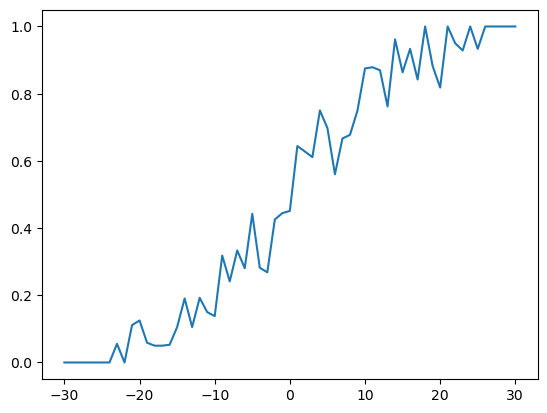

In [29]:
# plot predicted win percentage
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [30]:
# create spline model to smooth predictions
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.4430821108870794
logloss of cvsplit 1: 0.4418794172743277
logloss of cvsplit 2: 0.43980090240534975
logloss of cvsplit 3: 0.4385389076682199
logloss of cvsplit 4: 0.44346167904578343


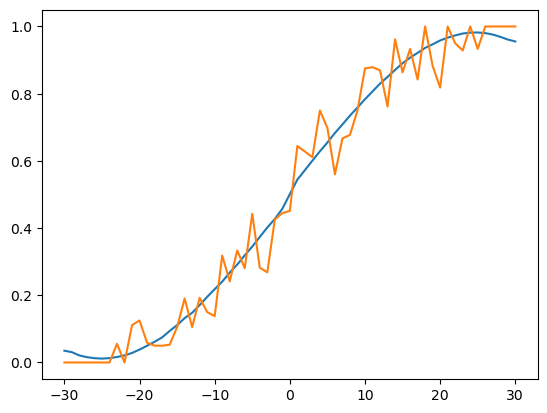

In [31]:
# plot spline model over xgb predictions
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [32]:
# recalculate spline model with range of probability 0.025-0.975
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}")

adjusted logloss of cvsplit 0: 0.4431927374294318
adjusted logloss of cvsplit 1: 0.44164574928911265
adjusted logloss of cvsplit 2: 0.4397857918334745
adjusted logloss of cvsplit 3: 0.4388005280819217
adjusted logloss of cvsplit 4: 0.44363742013482665


# Submission

In [33]:
sub = pd.read_csv("data/SampleSubmissionStage2.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104
3,2025_1101_1105,0.5,2025,1101,1105
4,2025_1101_1106,0.5,2025,1101,1106


In [34]:
sub['TeamSeasonID'] = sub['T1_TeamID'].astype(str) + "_" + sub['Season'].astype(str)
sub['Opp_TeamSeasonID'] = sub['T2_TeamID'].astype(str) + "_" + sub['Season'].astype(str)

# filter to men's teams
sub = sub[(sub['T1_TeamID'] > 2500) & (sub['T2_TeamID'] > 2500)]

# regular season
sub = pd.merge(sub, w_feat, on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, w_feat, left_on = 'Opp_TeamSeasonID', right_on= 'TeamSeasonID', how = 'left', suffixes=[None,'_Opp'])
sub.drop(columns=['TeamSeasonID_Opp'], inplace=True)

# team quality
sub = pd.merge(sub, glm_quality[['TeamSeasonID', 'quality']], on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, glm_quality[['Opp_TeamSeasonID', 'Opp_quality']], on = 'Opp_TeamSeasonID', how = 'left')

# tournament seeds
sub = pd.merge(sub, seeds_T1, on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, seeds_T2, on = 'Opp_TeamSeasonID', how = 'left')
sub['seed_diff'] = sub['seed'] - sub['Opp_seed']

# last 14 days
sub = pd.merge(sub, last14days_stats_T1, on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = 'Opp_TeamSeasonID', how = 'left')

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,TeamSeasonID,Opp_TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,quality,Opp_quality,seed,Opp_seed,seed_diff,win_ratio_14d,Opp_win_ratio_14d
0,2025_3101_3102,0.5,2025,3101,3102,3101_2025,3102_2025,68.413793,64.103448,0.068966,24.482759,57.241379,7.448276,24.655172,12.0,16.758621,9.482759,20.0,14.37931,17.206897,9.931034,2.37931,16.103448,23.517241,54.586207,7.034483,21.551724,10.034483,14.448276,8.275862,19.862069,13.206897,19.344828,9.827586,3.931034,17.448276,4.310345,0.427711,0.302098,0.716049,29.482759,0.430828,0.3264,0.694511,28.137931,0.165663,0.366393,0.151611,0.346988,0.430723,0.39482,0.587324,0.561584,0.262218,0.312971,82.827586,81.155172,0.043588,0.068675,0.529394,0.525926,65.433333,63.900000,0.066667,24.366667,60.900000,6.766667,20.966667,9.933333,14.000000,9.633333,18.933333,13.633333,12.866667,10.200000,2.366667,15.566667,24.100000,54.100000,5.766667,17.866667,9.933333,13.833333,8.333333,24.966667,13.400000,18.166667,7.000000,3.700000,14.466667,1.533333,0.400109,0.322734,0.709524,28.566667,0.445471,0.322761,0.718072,33.300000,0.158183,0.349969,0.154036,0.409962,0.344280,0.330253,0.559508,0.556017,0.189494,0.297733,80.766667,79.183333,0.043746,0.060755,0.487872,0.530848,-2.343999e-15,0.083474,NaN,NaN,NaN,0.333333,0.333333
1,2025_3101_3103,0.5,2025,3101,3103,3101_2025,3103_2025,68.413793,64.103448,0.068966,24.482759,57.241379,7.448276,24.655172,12.0,16.758621,9.482759,20.0,14.37931,17.206897,9.931034,2.37931,16.103448,23.517241,54.586207,7.034483,21.551724,10.034483,14.448276,8.275862,19.862069,13.206897,19.344828,9.827586,3.931034,17.448276,4.310345,0.427711,0.302098,0.716049,29.482759,0.430828,0.3264,0.694511,28.137931,0.165663,0.366393,0.151611,0.346988,0.430723,0.39482,0.587324,0.561584,0.262218,0.312971,82.827586,81.155172,0.043588,0.068675,0.529394,0.525926,61.448276,69.137931,0.000000,22.000000,55.275862,5.517241,20.034483,11.931034,17.379310,10.172414,21.793103,10.413793,17.310345,6.758621,2.482759,17.931034,24.724138,56.206897,7.689655,22.241379,12.000000,16.758621,8.034483,20.482759,12.689655,13.862069,7.724138,2.896552,17.448276,-7.689655,0.398004,0.275387,0.686508,31.965517,0.439877,0.345736,0.716049,28.517241,0.184030,0.387730,0.142945,0.370555,0.362445,0.395706,0.473354,0.513250,0.270620,0.214629,81.275862,78.448276,0.044172,0.052402,0.488283,0.543702,-2.343999e-15,-1.788035,NaN,NaN,NaN,0.333333,0.500000
2,2025_3101_3104,0.5,2025,3101,3104,3101_2025,3104_2025,68.413793,64.103448,0.068966,24.482759,57.241379,7.448276,24.655172,12.0,16.758621,9.482759,20.0,14.37931,17.206897,9.931034,2.37931,16.103448,23.517241,54.586207,7.034483,21.551724,10.034483,14.448276,8.275862,19.862069,13.206897,19.344828,9.827586,3.931034,17.448276,4.310345,0.427711,0.302098,0.716049,29.482759,0.430828,0.3264,0.694511,28.137931,0.165663,0.366393,0.151611,0.346988,0.430723,0.39482,0.587324,0.561584,0.262218,0.312971,82.827586,81.155172,0.043588,0.068675,0.529394,0.525926,78.354839,62.709677,0.032258,28.838710,62.258065,8.774194,22.709677,11.903226,17.354839,9.838710,24.677419,15.483871,13.774194,8.290323,4.612903,16.096774,22.903226,60.741935,4.967742,17.6451

In [35]:
# get sub features
Xsub = sub.iloc[:,7:].values
dtest = xgb.DMatrix(Xsub)

In [36]:
# building cv models for submission
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = d_train,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [37]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

# in previous competitions, some people have hard-coded against upsets
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""

sub[['ID','Pred']].to_csv("submissions/w_submission.csv", index = None)

In [38]:
# preview submissions df
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,TeamSeasonID,Opp_TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,quality,Opp_quality,seed,Opp_seed,seed_diff,win_ratio_14d,Opp_win_ratio_14d
0,2025_3101_3102,0.308937,2025,3101,3102,3101_2025,3102_2025,68.413793,64.103448,0.068966,24.482759,57.241379,7.448276,24.655172,12.0,16.758621,9.482759,20.0,14.37931,17.206897,9.931034,2.37931,16.103448,23.517241,54.586207,7.034483,21.551724,10.034483,14.448276,8.275862,19.862069,13.206897,19.344828,9.827586,3.931034,17.448276,4.310345,0.427711,0.302098,0.716049,29.482759,0.430828,0.3264,0.694511,28.137931,0.165663,0.366393,0.151611,0.346988,0.430723,0.39482,0.587324,0.561584,0.262218,0.312971,82.827586,81.155172,0.043588,0.068675,0.529394,0.525926,65.433333,63.900000,0.066667,24.366667,60.900000,6.766667,20.966667,9.933333,14.000000,9.633333,18.933333,13.633333,12.866667,10.200000,2.366667,15.566667,24.100000,54.100000,5.766667,17.866667,9.933333,13.833333,8.333333,24.966667,13.400000,18.166667,7.000000,3.700000,14.466667,1.533333,0.400109,0.322734,0.709524,28.566667,0.445471,0.322761,0.718072,33.300000,0.158183,0.349969,0.154036,0.409962,0.344280,0.330253,0.559508,0.556017,0.189494,0.297733,80.766667,79.183333,0.043746,0.060755,0.487872,0.530848,-2.343999e-15,0.083474,NaN,NaN,NaN,0.333333,0.333333
1,2025_3101_3103,0.414232,2025,3101,3103,3101_2025,3103_2025,68.413793,64.103448,0.068966,24.482759,57.241379,7.448276,24.655172,12.0,16.758621,9.482759,20.0,14.37931,17.206897,9.931034,2.37931,16.103448,23.517241,54.586207,7.034483,21.551724,10.034483,14.448276,8.275862,19.862069,13.206897,19.344828,9.827586,3.931034,17.448276,4.310345,0.427711,0.302098,0.716049,29.482759,0.430828,0.3264,0.694511,28.137931,0.165663,0.366393,0.151611,0.346988,0.430723,0.39482,0.587324,0.561584,0.262218,0.312971,82.827586,81.155172,0.043588,0.068675,0.529394,0.525926,61.448276,69.137931,0.000000,22.000000,55.275862,5.517241,20.034483,11.931034,17.379310,10.172414,21.793103,10.413793,17.310345,6.758621,2.482759,17.931034,24.724138,56.206897,7.689655,22.241379,12.000000,16.758621,8.034483,20.482759,12.689655,13.862069,7.724138,2.896552,17.448276,-7.689655,0.398004,0.275387,0.686508,31.965517,0.439877,0.345736,0.716049,28.517241,0.184030,0.387730,0.142945,0.370555,0.362445,0.395706,0.473354,0.513250,0.270620,0.214629,81.275862,78.448276,0.044172,0.052402,0.488283,0.543702,-2.343999e-15,-1.788035,NaN,NaN,NaN,0.333333,0.500000
2,2025_3101_3104,0.273662,2025,3101,3104,3101_2025,3104_2025,68.413793,64.103448,0.068966,24.482759,57.241379,7.448276,24.655172,12.0,16.758621,9.482759,20.0,14.37931,17.206897,9.931034,2.37931,16.103448,23.517241,54.586207,7.034483,21.551724,10.034483,14.448276,8.275862,19.862069,13.206897,19.344828,9.827586,3.931034,17.448276,4.310345,0.427711,0.302098,0.716049,29.482759,0.430828,0.3264,0.694511,28.137931,0.165663,0.366393,0.151611,0.346988,0.430723,0.39482,0.587324,0.561584,0.262218,0.312971,82.827586,81.155172,0.043588,0.068675,0.529394,0.525926,78.354839,62.709677,0.032258,28.838710,62.258065,8.774194,22.709677,11.903226,17.354839,9.838710,24.677419,15.483871,13.774194,8.290323,4.612903,16.096774,22.903226,60.741935,4

In [39]:
# create another submission with hard-coding against first-round upsets

"""
in previous competitions, some people have hard-coded against upsets
I'm only doing 1, 2, and 3 seeds
"""

sub.loc[(sub.seed==1) & (sub.Opp_seed==16), 'Pred'] = 1.0
sub.loc[(sub.seed==2) & (sub.Opp_seed==15), 'Pred'] = 1.0
sub.loc[(sub.seed==3) & (sub.Opp_seed==14), 'Pred'] = 1.0
#sub.loc[(sub.seed==4) & (sub.Opp_seed==13), 'Pred'] = 1.0
sub.loc[(sub.seed==16) & (sub.Opp_seed==1), 'Pred'] = 0.0
sub.loc[(sub.seed==15) & (sub.Opp_seed==2), 'Pred'] = 0.0
sub.loc[(sub.seed==14) & (sub.Opp_seed==3), 'Pred'] = 0.0
# sub.loc[(sub.seed==13) & (sub.Opp_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("submissions/w_submission_chalk.csv", index = None)